In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
import time

In [2]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
#build dataframe for n_seq output
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

# build timeseries data
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [4]:
train_cols = ["Precipitation","Temperature","Outflow"]
new_df = df.filter(train_cols, axis=1)

lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

lag_df

,Precipitation,Temperature,Outflow,Outflow(t+1)
0,0.0,102.992,5.0,5.0
1,0.0,97.790,5.0,5.0
2,0.0,92.588,5.0,5.0
3,0.0,87.404,5.0,5.0
4,0.0,85.172,5.0,5.0
...,...,...,...,...
185538,0.0,52.880,29.0,30.0
185539,0.0,54.284,30.0,29.0
185540,0.0,55.670,29.0,29.0
185541,0.0,57.074,29.0,31.0


In [5]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ["Outflow(t+1)"]

#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [6]:
x_train.shape, y_test.shape

((148434, 3), (37109, 1))

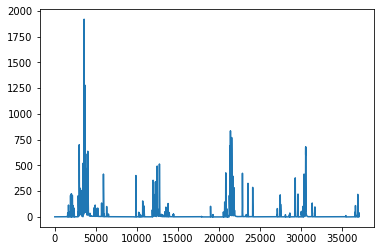

In [7]:
#store actual data 
y_train_actual = y_train
y_test_actual = y_test

#plot actual data
plt.figure()
plt.plot(y_test_actual)
plt.show()

In [8]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)


In [9]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



length of time-series i/o (148416, 18, 3) (148416,)



length of time-series i/o (37091, 18, 3) (37091,)


In [10]:
X_Train.shape,Y_Train.shape

((148416, 18, 3), (148416,))

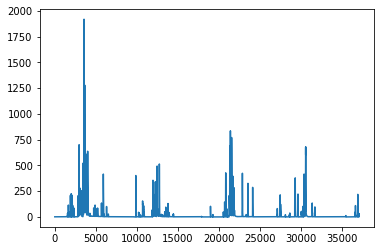

In [11]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [12]:
type(X_Train.shape)

tuple

In [13]:
X_Train_t,Y_Train_t,Y_train_actual_t=torch.FloatTensor(X_Train),torch.FloatTensor(Y_Train),torch.FloatTensor(Y_train_actual)

In [14]:
torch.set_printoptions(precision=10)

In [15]:
def input_merge(X_Train_t, Y_Train_t):
    out = []
    l = len(X_Train_t)
    for i in range(l):
        out.append((X_Train_t[i], Y_Train_t[i]))
    return out

train_data = input_merge(X_Train_t, Y_Train_t)

In [16]:
train_data[0]

(tensor([[0.0000000000, 0.8769030571, 0.0027716185],
         [0.0000000000, 0.8232454658, 0.0027716185],
         [0.0000000000, 0.7695878148, 0.0027716185],
         [0.0000000000, 0.7161158323, 0.0027716185],
         [0.0000000000, 0.6930931807, 0.0027716185],
         [0.0000000000, 0.6700705290, 0.0027716185],
         [0.0000000000, 0.6470478773, 0.0027716185],
         [0.0000000000, 0.6353508830, 0.0027716185],
         [0.0000000000, 0.6234682798, 0.0027716185],
         [0.0000000000, 0.6115856171, 0.0027716185],
         [0.0000000000, 0.6032305956, 0.0027716185],
         [0.0000000000, 0.5946899652, 0.0027716185],
         [0.0000000000, 0.5863349438, 0.0027716185],
         [0.0000000000, 0.5820646286, 0.0027716185],
         [0.0000000000, 0.5779799223, 0.0027716185],
         [0.0000000000, 0.5737096071, 0.0027716185],
         [0.0000000000, 0.6394355893, 0.0027716185],
         [0.0000000000, 0.7049758434, 0.0027716185]]),
 tensor(0.0022172949))

In [17]:
Y_Train_t[0]

tensor(0.0022172949)

In [18]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=3,hidden_size1=24, hidden_size2=50, hidden_size3=20,output_size=1):
        super().__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        
        # Add an LSTM and dropout layer:
        self.lstm1 = nn.LSTM(input_size,hidden_size1)
        self.dropout1 = nn.Dropout(p=0.2)
        
        # Add second LSTM and dropout layer:
        self.lstm2 = nn.LSTM(hidden_size1,hidden_size2)
        self.dropout2 = nn.Dropout(p=0.2)
        
        # Add a fully-connected layer:
        self.fc1 = nn.Linear(hidden_size2,hidden_size3)
        
        # Add a fully-connected layer:
        self.fc2 = nn.Linear(hidden_size3,output_size)
        
        # Initialize h0 and c0:
        self.hidden1 = (torch.zeros(1,1,self.hidden_size1),
                       torch.zeros(1,1,self.hidden_size1))
        
        # Initialize h1 and c1:
        self.hidden2 = (torch.zeros(1,1,self.hidden_size2),
                       torch.zeros(1,1,self.hidden_size2))

    def forward(self,seq):
        lstm1_out, self.hidden1 = self.lstm1(seq.view(len(seq),1,-1), self.hidden1)
        dropout1 = self.dropout1(lstm1_out)
        lstm2_out, self.hidden2 = self.lstm2(dropout1.view(len(dropout1),1,-1), self.hidden2)
        dropout2 = self.dropout2(lstm2_out)
        fc1_out = F.relu(self.fc1(dropout2))
        fc2_out = self.fc2(fc1_out)
        return fc2_out[-1]        

In [19]:
#model instatiation, loss funciton, optimization
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [20]:
model

LSTMnetwork(
  (lstm1): LSTM(3, 24)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(24, 50)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   288
  2304
    96
    96
  4800
 10000
   200
   200
  1000
    20
    20
     1
______
 19025


In [22]:
#training the model
epochs = 10

#to monitor training time
start_time = time.time()

for epoch in range(epochs):
    for seq, label in train_data:
        
        #reset the parameters and hidden states
        optimizer.zero_grad()        
        model.hidden1 = (torch.zeros(1,1,model.hidden_size1),
                       torch.zeros(1,1,model.hidden_size1))        
        
        model.hidden2 = (torch.zeros(1,1,model.hidden_size2),
                       torch.zeros(1,1,model.hidden_size2))
        
        y_pred_train = model(seq)
        
        loss = criterion(y_pred_train, label.reshape(1,1))
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00000000
Epoch:  2 Loss: 0.00000000
Epoch:  3 Loss: 0.00000063
Epoch:  4 Loss: 0.00000000
Epoch:  5 Loss: 0.00000000
Epoch:  6 Loss: 0.00000000


KeyboardInterrupt: 

In [26]:
train_data[0:2]

[(tensor([[0.0000000000, 0.8769030571, 0.0027716185],
          [0.0000000000, 0.8232454658, 0.0027716185],
          [0.0000000000, 0.7695878148, 0.0027716185],
          [0.0000000000, 0.7161158323, 0.0027716185],
          [0.0000000000, 0.6930931807, 0.0027716185],
          [0.0000000000, 0.6700705290, 0.0027716185],
          [0.0000000000, 0.6470478773, 0.0027716185],
          [0.0000000000, 0.6353508830, 0.0027716185],
          [0.0000000000, 0.6234682798, 0.0027716185],
          [0.0000000000, 0.6115856171, 0.0027716185],
          [0.0000000000, 0.6032305956, 0.0027716185],
          [0.0000000000, 0.5946899652, 0.0027716185],
          [0.0000000000, 0.5863349438, 0.0027716185],
          [0.0000000000, 0.5820646286, 0.0027716185],
          [0.0000000000, 0.5779799223, 0.0027716185],
          [0.0000000000, 0.5737096071, 0.0027716185],
          [0.0000000000, 0.6394355893, 0.0027716185],
          [0.0000000000, 0.7049758434, 0.0027716185]]),
  tensor(0.0022172949)),
 

In [24]:
cnt = 0
for seq, label in train_data:
    print(seq, end='\t')
    print(label)
    print(seq.shape)
    print((seq.view(len(seq),1,-1)).shape)
    cnt += 1
    if (cnt==1):
        break

tensor([[0.0000000000, 0.8769030571, 0.0027716185],
        [0.0000000000, 0.8232454658, 0.0027716185],
        [0.0000000000, 0.7695878148, 0.0027716185],
        [0.0000000000, 0.7161158323, 0.0027716185],
        [0.0000000000, 0.6930931807, 0.0027716185],
        [0.0000000000, 0.6700705290, 0.0027716185],
        [0.0000000000, 0.6470478773, 0.0027716185],
        [0.0000000000, 0.6353508830, 0.0027716185],
        [0.0000000000, 0.6234682798, 0.0027716185],
        [0.0000000000, 0.6115856171, 0.0027716185],
        [0.0000000000, 0.6032305956, 0.0027716185],
        [0.0000000000, 0.5946899652, 0.0027716185],
        [0.0000000000, 0.5863349438, 0.0027716185],
        [0.0000000000, 0.5820646286, 0.0027716185],
        [0.0000000000, 0.5779799223, 0.0027716185],
        [0.0000000000, 0.5737096071, 0.0027716185],
        [0.0000000000, 0.6394355893, 0.0027716185],
        [0.0000000000, 0.7049758434, 0.0027716185]])	tensor(0.0022172949)
torch.Size([18, 3])
torch.Size([18, 1, 3])